In [1]:
%matplotlib nbagg
%load_ext line_profiler

In [2]:
import time
import logging
from contextlib import contextmanager

import numpy as np
import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(level=logging.DEBUG)

In [4]:
from libertem.corrections.coordinates import flip_y, rotate_deg, identity
from libertem.masks import circular
from libertem.common.container import MaskContainer

In [5]:
from libertem_live.detectors.merlin import MerlinDataSocket, ReaderPool
from libertem_live.detectors.merlin.dataset import LiveDataSet
from libertem_live.api import LiveContext
from libertem_live.viz.base import LivePlot
from libertem_live.viz.mpl import MPLLivePlot

In [6]:
from ptychography.reconstruction.ssb import SSB_UDF, generate_masks
from ptychography.reconstruction.common import wavelength, get_shifted

## Camera setup

In [7]:
data_socket = MerlinDataSocket()
pool = ReaderPool(backend=data_socket, pool_size=2)

In [8]:
ds = LiveDataSet(
    scan_size=(128, 128),
    data_socket=data_socket,
    pool=pool,
    frames_per_partition=16*128,
)
ds = ds.initialize(None)  # TODO: integrate into LiveContext.load or how it will be called

In [9]:
def make_medipix_setup(data_socket, pool):
    @contextmanager
    def medipix_setup(dataset, udfs):
        print("priming camera for acquisition")
        # TODO: medipix control socket commands go here?
        
        # mer.set('numframes', 1024)
        # mer.set(...)
        
        with data_socket:
            yield
        print("camera teardown")
    return medipix_setup

In [10]:
livectx = LiveContext(make_medipix_setup(data_socket, pool))

DEBUG:asyncio:Using selector: EpollSelector


## SSB setup

In [11]:
ds_shape_sig, ds_shape_nav = ds.shape.sig, ds.shape.nav

# Acceleration voltage in keV
U = 300
rec_params = {
    "dtype": np.float32,
    "lamb": wavelength(U),
    "dpix": 12.7e-12,
    "semiconv": 22.1346e-3,  # 2020-05-18
    "semiconv_pix": 31,  # 2020-05-18
    # applied right to left
    "transformation": rotate_deg(88) @ flip_y(),
    "cx": 123,
    "cy": 126,
    "cutoff": 16,  # number of pixels: trotters smaller than this will be removed
}
cutoff_freq = np.float32('inf')

mask_params = {
    # Shape of the reconstructed area
    'reconstruct_shape': tuple(ds.shape.nav),
    # Shape of a detector frame
    'mask_shape': tuple(ds.shape.sig),
    # Use the faster shifting method to generate trotters
    'method': 'shift',
}

In [12]:
%%time
trotters = generate_masks(**rec_params, **mask_params)

DEBUG:numba.core.entrypoints:Loading extension: init = sparse._numba_extension:_init_extension
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=102)
           2	LOAD_GLOBAL(arg=0, lineno=102)
           4	LOAD_METHOD(arg=1, lineno=102)
           6	LOAD_GLOBAL(arg=0, lineno=102)
           8	LOAD_METHOD(arg=2, lineno=102)
          10	LOAD_FAST(arg=4, lineno=102)
          12	CALL_METHOD(arg=1, lineno=102)
          14	CALL_METHOD(arg=1, lineno=102)
          16	LOAD_GLOBAL(arg=0, lineno=102)
          18	LOAD_METHOD(arg=1, lineno=102)
          20	LOAD_GLOBAL(arg=0, lineno=102)
          22	LOAD_METHOD(arg=2, lineno=102)
          24	LOAD_FAST(arg=5, lineno=102)
          26	CALL_METHOD(arg=1, lineno=102)
          28	CALL_METHOD(arg=1, lineno=102)
          30	ROT_TWO(arg=None, lineno=102)
          32	STORE_FAST(arg=4, lineno=102)
          34	STORE_FAST(arg=5, lineno=102)
          36	LOAD_GLOBAL(arg=0, lineno=103)
          38	LOAD_METHOD(arg=3, lineno=1

DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$6load_global.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=4, lineno=102)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$8load_method.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=CALL_METHOD(arg=1, lineno=102)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$8load_method.3', '$sy10.4']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=CALL_METHOD(arg=1, lineno=102)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$12call_method.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=LOAD_GLOBAL(arg=0, lineno=102)
DEBUG:numba.core.byteflow:stack ['$14call_method.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_METHOD(arg=1, lineno=102)
DEBUG:numba.core.byteflow:stack ['$14call_method.6', '$16load_global.7']
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_GLOBAL(arg=0, lineno=102)
DEBUG:numba.core.byteflow:stack ['$14call_method.6', '$18load_method.8']
DEBUG:numba.core.byteflow:dispatch pc=2

DEBUG:numba.core.byteflow:dispatch pc=110, inst=LOAD_FAST(arg=1, lineno=117)
DEBUG:numba.core.byteflow:stack ['$98load_global.43', '$108call_method.48']
DEBUG:numba.core.byteflow:dispatch pc=112, inst=LOAD_FAST(arg=2, lineno=118)
DEBUG:numba.core.byteflow:stack ['$98load_global.43', '$108call_method.48', '$tile_origin110.49']
DEBUG:numba.core.byteflow:dispatch pc=114, inst=LOAD_GLOBAL(arg=0, lineno=119)
DEBUG:numba.core.byteflow:stack ['$98load_global.43', '$108call_method.48', '$tile_origin110.49', '$tile_shape112.50']
DEBUG:numba.core.byteflow:dispatch pc=116, inst=LOAD_METHOD(arg=5, lineno=119)
DEBUG:numba.core.byteflow:stack ['$98load_global.43', '$108call_method.48', '$tile_origin110.49', '$tile_shape112.50', '$114load_global.51']
DEBUG:numba.core.byteflow:dispatch pc=118, inst=LOAD_FAST(arg=4, lineno=119)
DEBUG:numba.core.byteflow:stack ['$98load_global.43', '$108call_method.48', '$tile_origin110.49', '$tile_shape112.50', '$116load_method.52']
DEBUG:numba.core.byteflow:dispatch p

DEBUG:numba.core.byteflow:stack ['$192binary_subscr.92', '$positive_tile194.93', '$200build_slice.97', '$sta_x202.98']
DEBUG:numba.core.byteflow:dispatch pc=206, inst=BUILD_SLICE(arg=2, lineno=124)
DEBUG:numba.core.byteflow:stack ['$192binary_subscr.92', '$positive_tile194.93', '$200build_slice.97', '$sta_x202.98', '$sto_x204.99']
DEBUG:numba.core.byteflow:dispatch pc=208, inst=BUILD_TUPLE(arg=2, lineno=124)
DEBUG:numba.core.byteflow:stack ['$192binary_subscr.92', '$positive_tile194.93', '$200build_slice.97', '$206build_slice.101']
DEBUG:numba.core.byteflow:dispatch pc=210, inst=STORE_SUBSCR(arg=None, lineno=124)
DEBUG:numba.core.byteflow:stack ['$192binary_subscr.92', '$positive_tile194.93', '$208build_tuple.102']
DEBUG:numba.core.byteflow:dispatch pc=212, inst=LOAD_FAST(arg=10, lineno=128)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=214, inst=LOAD_METHOD(arg=7, lineno=128)
DEBUG:numba.core.byteflow:stack ['$target_tup_n212.103']
DEBUG:numba.core.byteflow:

DEBUG:numba.core.byteflow:dispatch pc=302, inst=STORE_FAST(arg=18, lineno=135)
DEBUG:numba.core.byteflow:stack ['$300binary_multiply.150']
DEBUG:numba.core.byteflow:dispatch pc=304, inst=LOAD_FAST(arg=0, lineno=136)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=306, inst=LOAD_FAST(arg=7, lineno=136)
DEBUG:numba.core.byteflow:stack ['$center_tile304.151']
DEBUG:numba.core.byteflow:dispatch pc=308, inst=BINARY_MULTIPLY(arg=None, lineno=136)
DEBUG:numba.core.byteflow:stack ['$center_tile304.151', '$negative_tile306.152']
DEBUG:numba.core.byteflow:dispatch pc=310, inst=LOAD_FAST(arg=6, lineno=136)
DEBUG:numba.core.byteflow:stack ['$308binary_multiply.153']
DEBUG:numba.core.byteflow:dispatch pc=312, inst=LOAD_CONST(arg=2, lineno=136)
DEBUG:numba.core.byteflow:stack ['$308binary_multiply.153', '$positive_tile310.154']
DEBUG:numba.core.byteflow:dispatch pc=314, inst=COMPARE_OP(arg=2, lineno=136)
DEBUG:numba.core.byteflow:stack ['$308binary_multiply.153', '$positive_

DEBUG:numba.core.interpreter:label 0:
    center_tile = arg(0, name=center_tile)   ['center_tile']
    tile_origin = arg(1, name=tile_origin)   ['tile_origin']
    tile_shape = arg(2, name=tile_shape)     ['tile_shape']
    filter_center = arg(3, name=filter_center) ['filter_center']
    sy = arg(4, name=sy)                     ['sy']
    sx = arg(5, name=sx)                     ['sx']
    $2load_global.0 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>) ['$2load_global.0']
    $4load_method.1 = getattr(value=$2load_global.0, attr=int) ['$2load_global.0', '$4load_method.1']
    $6load_global.2 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>) ['$6load_global.2']
    $8load_method.3 = getattr(value=$6load_global.2, attr=round) ['$6load_global.2', '$8load_method.3']
    $12call_method.5 = call $8load_method.3(sy, func=$8load_method.3, args=[Var(sy, tro

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fdf81bb0>
DEBUG:numba.core.ssa:on stmt: center_tile = arg(0, name=center_tile)
DEBUG:numba.core.ssa:on stmt: tile_origin = arg(1, name=tile_origin)
DEBUG:numba.core.ssa:on stmt: tile_shape = arg(2, name=tile_shape)
DEBUG:numba.core.ssa:on stmt: filter_center = arg(3, name=filter_center)
DEBUG:numba.core.ssa:on stmt: sy = arg(4, name=sy)
DEBUG:numba.core.ssa:on stmt: sx = arg(5, name=sx)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=int)
DEBUG:numba.core.ssa:on stmt: $6load_global.2 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(

DEBUG:numba.core.ssa:on stmt: $142unpack_sequence.67 = static_getitem(value=$142unpack_sequence.69, index=2, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $142unpack_sequence.68 = static_getitem(value=$142unpack_sequence.69, index=3, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: sta_y = $142unpack_sequence.65
DEBUG:numba.core.ssa:on stmt: sto_y = $142unpack_sequence.66
DEBUG:numba.core.ssa:on stmt: sta_x = $142unpack_sequence.67
DEBUG:numba.core.ssa:on stmt: sto_x = $142unpack_sequence.68
DEBUG:numba.core.ssa:on stmt: $154unpack_sequence.73 = exhaust_iter(value=offsets_p, count=2)
DEBUG:numba.core.ssa:on stmt: $154unpack_sequence.71 = static_getitem(value=$154unpack_sequence.73, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $154unpack_sequence.72 = static_getitem(value=$154unpack_sequence.73, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: off_

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=90)
           2	LOAD_GLOBAL(arg=0, lineno=90)
           4	LOAD_METHOD(arg=1, lineno=90)
           6	LOAD_CONST(arg=1, lineno=90)
           8	CALL_METHOD(arg=1, lineno=90)
          10	LOAD_FAST(arg=0, lineno=90)
          12	BUILD_TUPLE(arg=2, lineno=90)
          14	STORE_FAST(arg=4, lineno=90)
          16	LOAD_FAST(arg=1, lineno=91)
          18	LOAD_FAST(arg=2, lineno=91)
          20	BUILD_TUPLE(arg=2, lineno=91)
          22	STORE_FAST(arg=5, lineno=91)
          24	LOAD_GLOBAL(arg=2, lineno=92)
          26	LOAD_FAST(arg=5, lineno=92)
          28	LOAD_FAST(arg=3, lineno=92)
          30	CALL_FUNCTION(arg=2, lineno=92)
          32	STORE_FAST(arg=6, lineno=92)
          34	LOAD_GLOBAL(arg=3, lineno=93)
          36	LOAD_FAST(arg=4, lineno=93)
          38	LOAD_FAST(arg=6, lineno=93)
          40	CALL_FUNCTION(arg=2, lineno=93)
          42	STORE_FAST(arg=7, lin

DEBUG:numba.core.byteflow:dispatch pc=60, inst=POP_JUMP_IF_FALSE(arg=90, lineno=94)
DEBUG:numba.core.byteflow:stack ['$58compare_op.24']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=62, stack=(), blockstack=(), npush=0), Edge(pc=90, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=62 nstack_initial=0), State(pc_initial=90 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=LOAD_GLOBAL(arg=0, lineno=96)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=64, inst=LOAD_METHOD(arg=1, lineno=96)
DEBUG:numba.core.byteflow:stack ['$62load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=LOAD_CONST(arg=1, lineno=96)
DEBUG:numba.core.byteflow:stack ['$64load_method.1']
DEBUG:numba.core.byteflow:dispatch pc=68, inst=LOAD_CONST(arg=1, lineno=96)
DEBUG:numba.core.byteflow:stack ['$64load_method.1', '$const66.2']
DEBUG:numba.core.byteflow:dispatch pc=70, inst=BUILD_L

DEBUG:numba.core.byteflow:stack ['$isect160.30', '$const162.31']
DEBUG:numba.core.byteflow:dispatch pc=166, inst=LOAD_FAST(arg=9, lineno=108)
DEBUG:numba.core.byteflow:stack ['$164binary_subscr.32']
DEBUG:numba.core.byteflow:dispatch pc=168, inst=LOAD_CONST(arg=3, lineno=108)
DEBUG:numba.core.byteflow:stack ['$164binary_subscr.32', '$targetslice166.33']
DEBUG:numba.core.byteflow:dispatch pc=170, inst=BINARY_SUBSCR(arg=None, lineno=108)
DEBUG:numba.core.byteflow:stack ['$164binary_subscr.32', '$targetslice166.33', '$const168.34']
DEBUG:numba.core.byteflow:dispatch pc=172, inst=BINARY_SUBTRACT(arg=None, lineno=108)
DEBUG:numba.core.byteflow:stack ['$164binary_subscr.32', '$170binary_subscr.35']
DEBUG:numba.core.byteflow:dispatch pc=174, inst=STORE_FAST(arg=13, lineno=108)
DEBUG:numba.core.byteflow:stack ['$172binary_subtract.36']
DEBUG:numba.core.byteflow:dispatch pc=176, inst=LOAD_FAST(arg=12, lineno=109)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=178, inst

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fdf04e80>
DEBUG:numba.core.ssa:on stmt: arr_shape = arg(0, name=arr_shape)
DEBUG:numba.core.ssa:on stmt: tile_origin = arg(1, name=tile_origin)
DEBUG:numba.core.ssa:on stmt: tile_shape = arg(2, name=tile_shape)
DEBUG:numba.core.ssa:on stmt: shift = arg(3, name=shift)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=array)
DEBUG:numba.core.ssa:on stmt: $const_0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const_0.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const6.2 = build_tuple(items=[Var($const_0, common.py:90), Var($const_0.1, common.py:90)])
DEBUG:numba.core.ssa:on stmt: $8call_method.3 = call $4load_method.1($const6.2, func=$4load_method.1, args=

DEBUG:numba.core.ssa:on stmt: $const168.34 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $170binary_subscr.35 = static_getitem(value=targetslice, index=0, index_var=$const168.34, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: offsets = $164binary_subscr.32 - $170binary_subscr.35
DEBUG:numba.core.ssa:on stmt: $180build_tuple.39 = build_tuple(items=[Var(target_tup, common.py:107), Var(offsets, common.py:108)])
DEBUG:numba.core.ssa:on stmt: $182return_value.40 = cast(value=$180build_tuple.39)
DEBUG:numba.core.ssa:on stmt: return $182return_value.40
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$100load_global.4': [<numba.core.ir.Assign object at 0x7f40fdf2fee0>],
             '$102load_global.5': [<numba.core.ir.Assign object at 0x7f40fdf310a0>],
             '$106load_global.7': [<numba.core.ir.Assign object at 0x7f40fdf31340>],
             '$108load_method.8': [<numba.core.ir.Assign object at 0x7f40fdf314c0>],
             '$112call_method.10': [<nu

DEBUG:numba.core.byteflow:stack ['$14binary_add.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=BUILD_TUPLE(arg=2, lineno=51)
DEBUG:numba.core.byteflow:stack ['$14binary_add.6', '$shape16.7']
DEBUG:numba.core.byteflow:dispatch pc=20, inst=RETURN_VALUE(arg=None, lineno=51)
DEBUG:numba.core.byteflow:stack ['$18build_tuple.8']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initi

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=205)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=205)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=2, lineno=205)
DEBUG:numba.core.byteflow:stack ['$src_ndim2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=COMPARE_OP(arg=4, lineno=205)
DEBUG:numba.core.byteflow:stack ['$src_ndim2.0', '$dest_ndim4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=POP_JUMP_IF_FALSE(arg=14, lineno=205)
DEBUG:numba.core.byteflow:stack ['$6compare_op.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=10, stack=(), blockstack=(), npush=0), Edge(pc=14, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=10 nstack_initial=0), State(pc_initial=14 nstack_initial=0)])
DEBUG:

DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=102, inst=LOAD_FAST(arg=4, lineno=226)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=104, inst=LOAD_CONST(arg=2, lineno=226)
DEBUG:numba.core.byteflow:stack ['$src_index102.0']
DEBUG:numba.core.byteflow:dispatch pc=106, inst=INPLACE_ADD(arg=None, lineno=226)
DEBUG:numba.core.byteflow:stack ['$src_index102.0', '$const104.1']
DEBUG:numba.core.byteflow:dispatch pc=108, inst=STORE_FAST(arg=4, lineno=226)
DEBUG:numba.core.byteflow:stack ['$106inplace_add.2']
DEBUG:numba.core.byteflow:dispatch pc=110, inst=LOAD_FAST(arg=5, lineno=227)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=112, inst=LOAD_CONST(arg=2, lineno=227)
DEBUG:numba.core.byteflow:stack ['$dest_index110.3']
DEBUG:numba.core.byteflow:dispatch pc=114, inst=INPLACE_ADD(arg=None, lineno=227)
DEBUG:numba.core.byteflow:stack ['$dest_index110.3', '$const112.4']
DEBUG:numba.core.byteflow:dispatch pc=116, inst=

DEBUG:numba.core.byteflow:block_infos State(pc_initial=86 nstack_initial=0):
AdaptBlockInfo(insts=((86, {'res': '$src_dim_size86.0'}), (88, {'res': '$const88.1'}), (90, {'lhs': '$src_dim_size86.0', 'rhs': '$const88.1', 'res': '$90compare_op.2'}), (92, {'pred': '$90compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={94: (), 102: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=94 nstack_initial=0):
AdaptBlockInfo(insts=((94, {'res': '$src_dim_size94.0'}), (96, {'res': '$dest_shape96.1'}), (98, {'res': '$dest_index98.2'}), (100, {'target': '$dest_shape96.1', 'index': '$dest_index98.2', 'value': '$src_dim_size94.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={102: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=102 nstack_initial=0):
AdaptBlockInfo(insts=((102, {'res': '$src_index102.0'}), (104, {'res': '$const104.1'}), (106, {'lhs': '$src_index102.0', 'rhs': '$const104.1', 'res': '$106in

DEBUG:numba.core.ssa:on stmt: bool32 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block analysis pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fde06e20>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const52.7 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $54compare_op.8 = dest_dim_size != $const52.7
DEBUG:numba.core.ssa:on stmt: bool56 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $56pred = call bool56($54compare_op.8, func=bool56, args=(Var($54compare_op.8, npyimpl.py:217),), kws=(), varar

DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fde58160>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=$const10.0)
DEBUG:numba.core.ssa:on stmt: return $12return_value.1
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 14
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fde58160>
D

DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='dest_index' stmt=dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:find_def_from_top label 26
DEBUG:numba.core.ssa:insert phi node dest_index.2 = phi(incoming_values=[], incoming_blocks=[]) at 26
DEBUG:numba.core.ssa:find_def_from_bottom label 102
DEBUG:numba.core.ssa:incoming_def dest_index.1 = $114inplace_add.5
DEBUG:numba.core.ssa:find_def_from_bottom label 14
DEBUG:numba.core.ssa:incoming_def dest_index = dest_ndim - src_ndim
DEBUG:numba.core.ssa:replaced with: dest_dim_size = getitem(value=dest_shape, index=d

DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=$const10.0)
DEBUG:numba.core.ssa:on stmt: return $12return_value.1
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 14
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fde68820>
DEBUG:numba.core.ssa:on stmt: src_index = const(int, 0)
DEBUG:numba.core.ssa:first assign: src_index
DEBUG:numba.core.ssa:replaced with: src_index = const(int, 0)
DEBUG:numba.core.ssa:on stmt: dest_index = dest_ndim - src_ndim
DEBUG:numba.core.ssa:on stmt: jump 26
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 26
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fde68820>
DEBUG:numba.core.ssa:on stmt: dest_index.2 = phi(incoming_values=[Var(dest_index.1, npyimpl.py:227), Var(dest_index, npyimpl.py:211)], incoming_blocks=[102, 14])
DEBUG:numba.core.ssa:on stmt: $30compare_op.2 = src_index < src_ndim
DEBUG:numba.core.ssa:on stmt: boo

DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fde58040>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='src_index' stmt=src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:replaced with: src_dim_size = getitem(value=src_shape, index=src_index.2, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index.2, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const52.7 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $54compare_op.8 = dest_dim_size != $const52.7
DEBUG:numba.core.ssa:on

DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=5, lineno=69)
DEBUG:numba.core.byteflow:stack ['$12unpack_sequence.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_GLOBAL(arg=0, lineno=71)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_METHOD(arg=1, lineno=71)
DEBUG:numba.core.byteflow:stack ['$18load_global.8']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=LOAD_FAST(arg=2, lineno=71)
DEBUG:numba.core.byteflow:stack ['$20load_method.9']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=LOAD_FAST(arg=4, lineno=71)
DEBUG:numba.core.byteflow:stack ['$20load_method.9', '$o122.10']
DEBUG:numba.core.byteflow:dispatch pc=26, inst=CALL_METHOD(arg=2, lineno=71)
DEBUG:numba.core.byteflow:stack ['$20load_method.9', '$o122.10', '$o224.11']
DEBUG:numba.core.byteflow:dispatch pc=28, inst=STORE_FAST(arg=6, lineno=71)
DEBUG:numba.core.byteflow:stack ['$26call_method.12']
DEBUG:numba.core.byteflow:dispatch pc=30, inst=LOAD_GLOBAL(arg=0, lineno=

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fdeeb250>
DEBUG:numba.core.ssa:on stmt: s1 = arg(0, name=s1)
DEBUG:numba.core.ssa:on stmt: s2 = arg(1, name=s2)
DEBUG:numba.core.ssa:on stmt: $4unpack_sequence.3 = exhaust_iter(value=s1, count=2)
DEBUG:numba.core.ssa:on stmt: $4unpack_sequence.1 = static_getitem(value=$4unpack_sequence.3, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $4unpack_sequence.2 = static_getitem(value=$4unpack_sequence.3, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: o1 = $4unpack_sequence.1
DEBUG:numba.core.ssa:on stmt: ss1 = $4unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: $12unpack_sequence.7 = exhaust_iter(value=s2, count=2)
DEBUG:numba.core.ssa:on stmt: $12unpack_sequence.5 = static_getitem(value=$12unpack_sequence.7, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.s

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fdc76580>
DEBUG:numba.core.ssa:on stmt: o1_1 = arg(0, name=o1_1)
DEBUG:numba.core.ssa:on stmt: o2_1 = arg(1, name=o2_1)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(__ufunc_or_dufunc_0x7f42042478b: <ufunc 'maximum'>)
DEBUG:numba.core.ssa:on stmt: $8call_function.3 = call $2load_global.0(o1_1, o2_1, func=$2load_global.0, args=[Var(o1_1, common.py:1), Var(o2_1, common.py:1)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10return_value.4 = cast(value=$8call_function.3)
DEBUG:numba.core.ssa:on stmt: return $10return_value.4
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$10return_value.4': [<numba.core.ir.Assign object at 0x7f40fdc7c4c0>],
             '$2load_global.0': [<numba.core.ir.Assign object at 0x7f40fdc76f40>],
             '$8call_function.3': [<numba.core.ir.Assign object at 0x7f40fdc7c370>],
             'o

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=1)
           2	LOAD_GLOBAL(arg=0, lineno=1)
           4	LOAD_CONST(arg=1, lineno=1)
           6	LOAD_FAST(arg=0, lineno=72)
           8	CALL_FUNCTION(arg=2, lineno=1)
          10	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=1)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=1)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=72)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=CALL_FUNCTION(arg=2, lin

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fdde2f70>
DEBUG:numba.core.ssa:on stmt: s1 = arg(0, name=s1)
DEBUG:numba.core.ssa:on stmt: s2 = arg(1, name=s2)
DEBUG:numba.core.ssa:on stmt: $4unpack_sequence.3 = exhaust_iter(value=s1, count=2)
DEBUG:numba.core.ssa:on stmt: $4unpack_sequence.1 = static_getitem(value=$4unpack_sequence.3, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $4unpack_sequence.2 = static_getitem(value=$4unpack_sequence.3, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: o1 = $4unpack_sequence.1
DEBUG:numba.core.ssa:on stmt: ss1 = $4unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: $12unpack_sequence.7 = exhaust_iter(value=s2, count=2)
DEBUG:numba.core.ssa:on stmt: $12unpack_sequence.5 = static_getitem(value=$12unpack_sequence.7, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.s

DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$s12.0'}), (4, {'iterable': '$s12.0', 'stores': ['$4unpack_sequence.1', '$4unpack_sequence.2'], 'tupleobj': '$4unpack_sequence.3'}), (6, {'value': '$4unpack_sequence.1'}), (8, {'value': '$4unpack_sequence.2'}), (10, {'res': '$origin10.4'}), (12, {'res': '$ss112.5'}), (14, {'items': ['$origin10.4', '$ss112.5'], 'res': '$14build_tuple.6'}), (16, {'retval': '$14build_tuple.6', 'castval': '$16return_value.7'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    s1 = arg(0, name=s1)                     ['s1']
    origin = arg(1, name=origin)             ['origin']
    $4unpack_sequence.3 = exhaust_iter(value=s1, count=2) ['$4unpack_sequence.3', 's1']
    $4unpack_sequence.1 = static_getitem(value=$4unpack_sequence.3, index=0, index_var=None, fn=<built-in function getitem>) ['$4unpack_sequence.1', '$4un

DEBUG:numba.core.byteflow:defmap: {'$phi16.0': State(pc_initial=0 nstack_initial=0),
 '$phi18.1': State(pc_initial=16 nstack_initial=1)}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>,
            {'$phi16.0': {('$14get_iter.5',
                           State(pc_initial=0 nstack_initial=0)),
                          ('$phi18.0', State(pc_initial=18 nstack_initial=2))},
             '$phi18.0': {('$phi16.0', State(pc_initial=16 nstack_initial=1))},
             '$phi18.1': {('$16for_iter.2',
                           State(pc_initial=16 nstack_initial=1))}})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi16.0': {('$14get_iter.5',
                           State(pc_initial=0 nstack_initial=0)),
                          ('$phi16.0', State(pc_initial=16 nstack_initial=1))},
             '$phi18.0': {('$14get_iter.5',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi18.1': {('$16for_iter.2',
  

DEBUG:numba.core.ssa:on stmt: $36return_value.1 = cast(value=c)
DEBUG:numba.core.ssa:on stmt: return $36return_value.1
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$12call_method.4': [<numba.core.ir.Assign object at 0x7f40fda7c250>],
             '$14get_iter.5': [<numba.core.ir.Assign object at 0x7f40fda7c3a0>],
             '$16for_iter.1': [<numba.core.ir.Assign object at 0x7f40fda7c6a0>],
             '$16for_iter.2': [<numba.core.ir.Assign object at 0x7f40fda7c7c0>],
             '$16for_iter.3': [<numba.core.ir.Assign object at 0x7f40fda7c8e0>],
             '$24load_method.4': [<numba.core.ir.Assign object at 0x7f40fda7cf40>],
             '$26call_method.5': [<numba.core.ir.Assign object at 0x7f40fda7e130>],
             '$28inplace_multiply.6': [<numba.core.ir.Assign object at 0x7f40fda7e280>],
             '$36return_value.1': [<numba.core.ir.Assign object at 0x7f40fda7e6a0>],
             '$6load_global.1': [<numba.core.ir.Assign object at 0x7f40fdaf04

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=2716)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=2716)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=2716)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=2716)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$shape4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=2, lineno=2716)
DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=1, lineno=2717)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=2, lineno=2717)
DEBUG:numba.core.byteflow:stack ['$10load_global.3']
DEBUG:numba.co

DEBUG:numba.core.byteflow:keep phismap: {'$phi18.0': {('$16get_iter.6', State(pc_initial=0 nstack_initial=0))},
 '$phi20.1': {('$18for_iter.2', State(pc_initial=18 nstack_initial=1))}}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi18.0': '$16get_iter.6'},
             State(pc_initial=18 nstack_initial=1): {'$phi20.1': '$18for_iter.2'}})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$2load_global.0'}), (4, {'res': '$shape4.1'}), (6, {'func': '$2load_global.0', 'args': ['$shape4.1'], 'res': '$6call_function.2'}), (8, {'value': '$6call_function.2'}), (10, {'res': '$10load_global.3'}), (12, {'res': '$n12.4'}), (14, {'func': '$10load_global.3', 'args': ['$n12.4'], 'res': '$14call_function.5'}), (16, {'value': '$14call_function.5', 'res': '$16get_iter.6'})), o

DEBUG:numba.core.ssa:on stmt: $44binary_subscr.13 = getitem(value=main_shape, index=$42binary_add.12, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $46compare_op.14 = $26binary_subscr.4 != $44binary_subscr.13
DEBUG:numba.core.ssa:on stmt: bool48 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $48pred = call bool48($46compare_op.14, func=bool48, args=(Var($46compare_op.14, arrayobj.py:2718),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $48pred, 50, 18
DEBUG:numba.core.ssa:==== SSA block analysis pass on 50
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd9fd9d0>
DEBUG:numba.core.ssa:on stmt: $50load_global.1 = global(ValueError: <class 'ValueError'>)
DEBUG:numba.core.ssa:on stmt: $const52.2 = const(str, nditer(): operands could not be broadcast together)
DEBUG:numba.core.ssa:on stmt: $54call_function.3 = call $50load_global.1($const52.2, func=$50load_global.1, args=[Var($const52.2, arrayobj.py:2719)], kws=(), v

DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$_164binary_subscr_32_12.0'}), (4, {'res': '$_170binary_subscr_35_14.1'}), (6, {'lhs': '$_164binary_subscr_32_12.0', 'rhs': '$_170binary_subscr_35_14.1', 'res': '$6binary_subtract.2'}), (8, {'retval': '$6binary_subtract.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _164binary_subscr_32_1 = arg(0, name=_164binary_subscr_32_1) ['_164binary_subscr_32_1']
    _170binary_subscr_35_1 = arg(1, n

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=1602)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_CONST(arg=1, lineno=1602)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=STORE_FAST(arg=2, lineno=1602)
DEBUG:numba.core.byteflow:stack ['$const2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_CONST(arg=2, lineno=1603)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=1603)
DEBUG:numba.core.byteflow:stack ['$const6.1']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=0, lineno=1604)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=1604)
DEBUG:numba.core.byteflow:stack ['$10load_global.2']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=CALL_FUNCTION(

DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=18, stack=('$phi48.0',), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=74 nstack_initial=0), State(pc_initial=164 nstack_initial=0), State(pc_initial=92 nstack_initial=0), State(pc_initial=156 nstack_initial=0), State(pc_initial=18 nstack_initial=1), State(pc_initial=18 nstack_initial=1)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=74, inst=LOAD_GLOBAL(arg=1, lineno=1613)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=76, inst=LOAD_CONST(arg=3, lineno=1613)
DEBUG:numba.core.byteflow:stack ['$74load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=78, inst=CALL_FUNCTION(arg=1, lineno=1613)
DEBUG:numba.core.byteflow:stack ['$74load_global.0', '$const76.1']
DEBUG:numba.core.byteflow:dispatch pc=80, inst=RAISE_VARARGS(arg=1, lineno=1613)
DEBUG:numba.core.byteflow:stack ['$78call_function.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:nu

DEBUG:numba.core.byteflow:dispatch pc=150, inst=LOAD_FAST(arg=6, lineno=1625)
DEBUG:numba.core.byteflow:stack ['$inferred146.0', '$shape148.1']
DEBUG:numba.core.byteflow:dispatch pc=152, inst=STORE_SUBSCR(arg=None, lineno=1625)
DEBUG:numba.core.byteflow:stack ['$inferred146.0', '$shape148.1', '$neg_ax150.2']
DEBUG:numba.core.byteflow:dispatch pc=154, inst=JUMP_FORWARD(arg=8, lineno=1625)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=164, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=164 nstack_initial=0)])
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=18 nstack_initial=1): {'$phi18.0'},
             State(pc_initial=20 nstack_initial=2): {'$phi20.1'},
             State(pc_initial=34 nstack_initial=1): set(),

DEBUG:numba.core.byteflow:block_infos State(pc_initial=74 nstack_initial=0):
AdaptBlockInfo(insts=((74, {'res': '$74load_global.0'}), (76, {'res': '$const76.1'}), (78, {'func': '$74load_global.0', 'args': ['$const76.1'], 'res': '$78call_function.2'}), (80, {'exc': '$78call_function.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=84 nstack_initial=0):
AdaptBlockInfo(insts=((84, {'res': '$num_neg_value84.0'}), (86, {'res': '$const86.1'}), (88, {'lhs': '$num_neg_value84.0', 'rhs': '$const86.1', 'res': '$88compare_op.2'}), (90, {'pred': '$88compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={92: (), 156: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=92 nstack_initial=0):
AdaptBlockInfo(insts=((92, {'res': '$known_size92.0'}), (94, {'res': '$const94.1'}), (96, {'lhs': '$known_size92.0', 'rhs': '$const94.1', 'res': '$96compare_op.2'}), (98, {'

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd4b3df0>
DEBUG:numba.core.ssa:on stmt: origsize = arg(0, name=origsize)
DEBUG:numba.core.ssa:on stmt: shape = arg(1, name=shape)
DEBUG:numba.core.ssa:on stmt: num_neg_value = const(int, 0)
DEBUG:numba.core.ssa:on stmt: known_size = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $10load_global.2 = global(enumerate: <class 'enumerate'>)
DEBUG:numba.core.ssa:on stmt: $14call_function.4 = call $10load_global.2(shape, func=$10load_global.2, args=[Var(shape, arrayobj.py:1602)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
DEBUG:numba.core.ssa:on stmt: $phi18.0 = $16get_iter.5
DEBUG:numba.core.ssa:on stmt: jump 18
DEBUG:numba.core.ssa:==== SSA block analysis pass on 18
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd4b3df0>
DEBUG:numba.core.ssa:on stmt: $18for_iter.1 = iter

DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd4b3df0>
DEBUG:numba.core.ssa:on stmt: $156load_global.0 = global(ValueError: <class 'ValueError'>)
DEBUG:numba.core.ssa:on stmt: $const158.1 = const(str, multiple negative shape values)
DEBUG:numba.core.ssa:on stmt: $160call_function.2 = call $156load_global.0($const158.1, func=$156load_global.0, args=[Var($const158.1, arrayobj.py:1628)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: <static> raise <class 'ValueError'>('multiple negative shape values')
DEBUG:numba.core.ssa:==== SSA block analysis pass on 164
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd4b3df0>
DEBUG:numba.core.ssa:on stmt: $const164.0 = const(NoneType, None)
DEBUG:numba.core.ssa:on stmt: $166return_value.1 = cast(value=$const164.0)
DEBUG:numba.core.ssa:on stmt: return $166return_value.1
DEBUG:numba.core.ssa:==== SSA block analysis pass on 165
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDef

DEBUG:numba.core.ssa:on stmt: $const28.6 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $30compare_op.7 = s < $const28.6
DEBUG:numba.core.ssa:on stmt: bool32 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.7, func=bool32, args=(Var($30compare_op.7, arrayobj.py:1605),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 48
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd4b3df0>
DEBUG:numba.core.ssa:on stmt: $const36.2 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $38inplace_add.3 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=num_neg_value, rhs=$const36.2, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: num_neg_value = $38inplace_add.3
DEBUG:numba.core.ssa:on stmt: neg_ax = ax
DEBUG:numba.core.ssa:on stmt: jump 165
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48


DEBUG:numba.core.ssa:on stmt: $16get_iter.5 = getiter(value=$14call_function.4)
DEBUG:numba.core.ssa:on stmt: $phi18.0 = $16get_iter.5
DEBUG:numba.core.ssa:on stmt: jump 18
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 18
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd43fd60>
DEBUG:numba.core.ssa:on stmt: $18for_iter.1 = iternext(value=$phi18.0)
DEBUG:numba.core.ssa:on stmt: $18for_iter.2 = pair_first(value=$18for_iter.1)
DEBUG:numba.core.ssa:on stmt: $18for_iter.3 = pair_second(value=$18for_iter.1)
DEBUG:numba.core.ssa:on stmt: $phi20.1 = $18for_iter.2
DEBUG:numba.core.ssa:on stmt: branch $18for_iter.3, 20, 58
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 20
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd43fd60>
DEBUG:numba.core.ssa:on stmt: $20unpack_sequence.4 = exhaust_iter(value=$phi20.1, count=2)
DEBUG:numba.core.ssa:on stmt: $20unpack_sequence.2 = static_getitem(value=$20unpack_sequence.4, index=0, index_var=Non

DEBUG:numba.core.ssa:on stmt: $98pred = call bool98($96compare_op.2, func=bool98, args=(Var($96compare_op.2, arrayobj.py:1617),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $98pred, 100, 114
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 100
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd43fd60>
DEBUG:numba.core.ssa:on stmt: inferred = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const106.2 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: ok = origsize == $const106.2
DEBUG:numba.core.ssa:on stmt: jump 134
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 114
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd43fd60>
DEBUG:numba.core.ssa:on stmt: inferred = origsize // known_size
DEBUG:numba.core.ssa:find_def var='known_size' stmt=inferred = origsize // known_size
DEBUG:numba.core.ssa:find_def_from_top label 114
DEBUG:numba.core.ssa:idom 92 from label 114
DEBUG:numba.core.ssa:find_def_from_bottom label 92
DEBUG:numba

CPU times: user 7.13 s, sys: 3.01 s, total: 10.1 s
Wall time: 6.01 s


In [13]:
trotters

Format,coo
Data Type,float32
Shape,"(8320, 256, 256)"
nnz,2592705
Density,0.004754992631765513
Read-only,True
Size,69.2M
Storage ratio,0.0


In [14]:
mask_container = MaskContainer(
    mask_factories=lambda: trotters, dtype=trotters.dtype, count=trotters.shape[0]
)

In [15]:
ssb_udf = SSB_UDF(**rec_params, mask_container=mask_container)

## SSB on live data

<IPython.core.display.Javascript object>


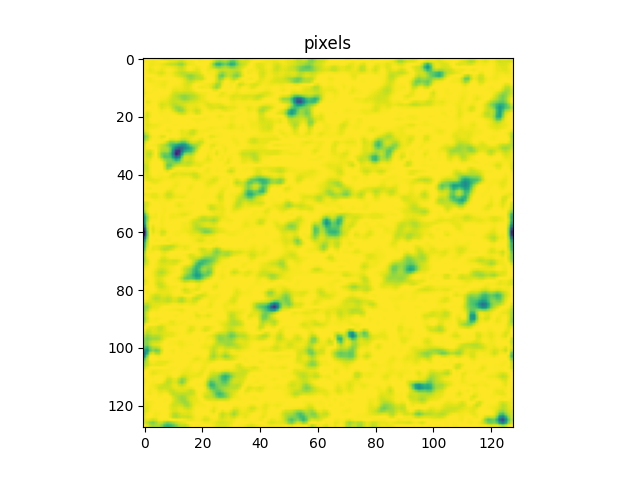

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<F

<IPython.core.display.Javascript object>


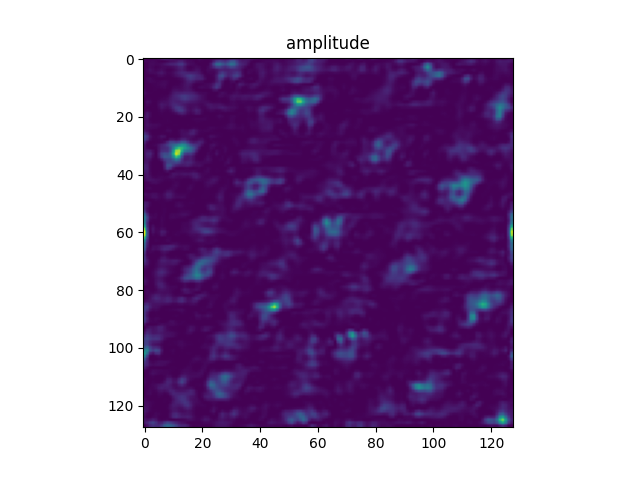

<IPython.core.display.Javascript object>


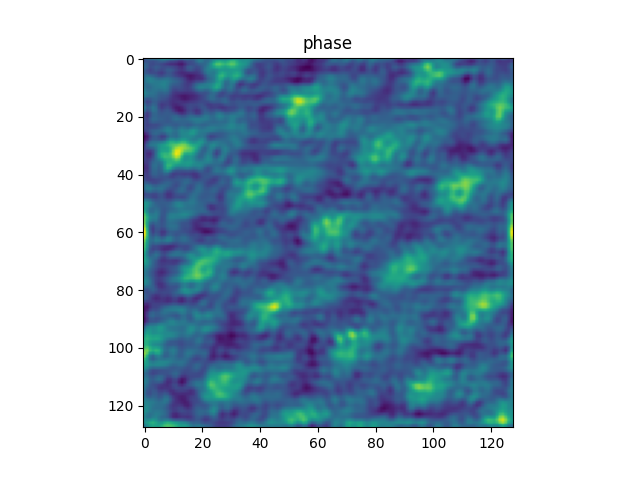

DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [192, 64, 1]
DEBUG:libertem.io.dataset.base.tiling:tileshape before adjustment: ((192, 64, 256),)
DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((24, 256, 256),)
DEBUG:libertem_live.detectors.merlin.dataset:reading up to frame idx 2048 for this partition


priming camera for acquisition
depth=24


DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
/home/alex/source/modules/LiberTEM-live/src/libertem_live/viz/base.py:27: ComplexWarning: Casting 

depth=24


DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.081 seconds
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.ti

depth=24


DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.084 seconds
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.ti

depth=24


DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.073 seconds
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.ti

depth=24


DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [192, 64, 1]
DEBUG:libertem.io.datas

depth=24


DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.103 seconds
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.ti

depth=24


DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.083 seconds
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=3145728, min_factors=(192, 64, 1)
DEBUG:libertem.io.dataset.base.ti

depth=24


DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.110 seconds
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: stopping threads
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: stop signal set
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl: thread joined
DEBUG:libertem_live.detectors.merlin.data:ReaderPoolImpl.__exit__: threads stopped
DEBUG:libertem_live.detectors.merlin.dataset:LivePartition.get_tiles: end of method
DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.082 seconds
DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.066 seconds
DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.091 seconds
DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.036 seconds
DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.035 seconds
DEBUG:libertem_live.viz.mpl:MPLLivePlot updated in 0.035 seconds


camera teardown


In [16]:
await livectx.run_udfs(dataset=ds, udfs=[ssb_udf])

## Offline Data

In [17]:
from libertem.api import Context

In [18]:
from libertem.executor.inline import InlineJobExecutor

In [19]:
ctx = Context(executor=InlineJobExecutor())

In [20]:
ds_offline = ctx.load("mib", path="/cachedata/reference/MIB/20200518 165148/default.hdr")

DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [21]:
from libertem.udf.sum import SumUDF

In [22]:
%%time
ctx.run_udf(dataset=ds_offline, udf=SumUDF())

DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=262144, min_factors=(16, 64, 1)
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [16, 64, 1]
DEBUG:libertem.io.dataset.base.tiling:tileshape before adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((16, 64, 256),)
INFO:libertem.common.numba:cache hit for <function make_get_read_ranges.<locals>._get_read_ranges_inner at 0x7f41dd0eda60>, load took 0.010s
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=52)
           2	LOAD_GLOBAL(arg=0, lineno=52)
           4	LO

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=390)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=1, lineno=390)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=390)
DEBUG:numba.core.byteflow:stack ['$allocated2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=COMPARE_OP(arg=0, lineno=390)
DEBUG:numba.core.byteflow:stack ['$allocated2.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=POP_JUMP_IF_FALSE(arg=18, lineno=390)
DEBUG:numba.core.byteflow:stack ['$6compare_op.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=10, stack=(), blockstack=(), npush=0), Edge(pc=18, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=10 nstack_initial=0), State(pc_initial=18 nstack_initial=0)])
DEBUG:n

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd246070>
DEBUG:numba.core.ssa:on stmt: item = arg(0, name=item)
DEBUG:numba.core.ssa:on stmt: allocated = arg(1, name=allocated)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = allocated < $const4.1
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, listobject.py:390),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 18
DEBUG:numba.core.ssa:==== SSA block analysis pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd246070>
DEBUG:numba.core.ssa:on stmt: $10load_global.0 = global(RuntimeError: <class 'RuntimeError'>)
DEBUG:numba.core.ssa:on stmt: $const12.1 = const(str, expecting *allocated* to be >= 0)
DEBUG:numba.core

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=598)
           2	LOAD_GLOBAL(arg=0, lineno=598)
           4	LOAD_FAST(arg=1, lineno=598)
           6	LOAD_DEREF(arg=0, lineno=598)
           8	CALL_FUNCTION(arg=2, lineno=598)
          10	STORE_FAST(arg=2, lineno=598)
          12	LOAD_GLOBAL(arg=1, lineno=599)
          14	LOAD_FAST(arg=0, lineno=599)
          16	LOAD_FAST(arg=2, lineno=599)
          18	CALL_FUNCTION(arg=2, lineno=599)
          20	STORE_FAST(arg=3, lineno=599)
          22	LOAD_FAST(arg=3, lineno=600)
          24	LOAD_GLOBAL(arg=2, lineno=600)
          26	LOAD_ATTR(arg=3, lineno=600)
          28	COMPARE_OP(arg=2, lineno=600)
          30	POP_JUMP_IF_FALSE(arg=36, lineno=600)
          32	LOAD_CONST(arg=0, lineno=601)
          34	RETURN_VALUE(arg=None, lineno=601)
>         36	LOAD_FAST(arg=3, lineno=602)
          38	LOAD_GLOBAL(arg=2, lineno=602)
          40	LOAD_ATTR(arg=4, lineno=602)
   

DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=76, inst=LOAD_GLOBAL(arg=8, lineno=607)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=78, inst=LOAD_CONST(arg=3, lineno=607)
DEBUG:numba.core.byteflow:stack ['$76load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=80, inst=CALL_FUNCTION(arg=1, lineno=607)
DEBUG:numba.core.byteflow:stack ['$76load_global.0', '$const78.1']
DEBUG:numba.core.byteflow:dispatch pc=82, inst=RAISE_VARARGS(arg=1, lineno=607)
DEBUG:numba.core.byteflow:stack ['$80call_function.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=32 nstack_initial=0): set(),
             State(pc_initial=36 nstack_initial=0): set(),
             State(pc_initial=46 nstack_initial=0): set(),
       

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd577940>
DEBUG:numba.core.ssa:on stmt: l = arg(0, name=l)
DEBUG:numba.core.ssa:on stmt: item = arg(1, name=item)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(_cast: <intrinsic _cast>)
DEBUG:numba.core.ssa:on stmt: $6load_deref.2 = freevar(itemty: readonly array(uint8, 1d, C))
DEBUG:numba.core.ssa:on stmt: casteditem = call $2load_global.0(item, $6load_deref.2, func=$2load_global.0, args=[Var(item, listobject.py:598), Var($6load_deref.2, listobject.py:598)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $12load_global.4 = global(_list_append: <intrinsic _list_append>)
DEBUG:numba.core.ssa:on stmt: status = call $12load_global.4(l, casteditem, func=$12load_global.4, args=[Var(l, listobject.py:598), Var(casteditem, listobject.py:598)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $24load_global.9 = global(ListStatus: <enum 'ListStatus

DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [16, 64, 1]
DEBUG:libertem.io.dataset.base.tiling:tileshape before adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=262144, min_factors=(16, 64, 1)
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [16, 64, 1]
DEBUG:libertem.io.dataset.base.tiling:tileshape before adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.backen

CPU times: user 1.26 s, sys: 35.9 ms, total: 1.29 s
Wall time: 1.27 s


{'intensity': <BufferWrapper kind=sig dtype=float32 extra_shape=()>}

In [23]:
%%time
yarrrrrrr = ctx.run_udf(dataset=ds_offline, udf=ssb_udf)

DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=262144, min_factors=(16, 64, 1)
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [16, 64, 1]
DEBUG:libertem.io.dataset.base.tiling:tileshape before adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=466)
           2	LOAD_GLOBAL(arg=0, lineno=466)
           4	LOAD_ATTR(arg=1, lineno=466)
           6	LOAD_ATTR(arg=2, lineno=466)
           8	LOAD_METHOD(arg=3, lineno=466)
          10	LOAD_GLOBAL(a

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=466)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_ATTR(arg=1, lineno=466)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_ATTR(arg=2, lineno=466)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=LOAD_METHOD(arg=3, lineno=466)
DEBUG:numba.core.byteflow:stack ['$6load_attr.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=0, lineno=466)
DEBUG:numba.core.byteflow:stack ['$8load_method.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_ATTR(arg=4, lineno=466)
DEBUG:numba.core.byteflow:stack ['$8load_method.3', '$10load_global.4']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_ATTR(arg=5, lineno=466)
DEBUG:numba.core.byteflow:stack ['$8load_method.3', '$12load_attr.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=CAL

DEBUG:numba.core.byteflow:stack ['$104load_global.3', '$106load_global.4', '$indices108.5', '$i110.6', '$const112.7']
DEBUG:numba.core.byteflow:dispatch pc=116, inst=BINARY_SUBSCR(arg=None, lineno=481)
DEBUG:numba.core.byteflow:stack ['$104load_global.3', '$106load_global.4', '$indices108.5', '$114build_tuple.8']
DEBUG:numba.core.byteflow:dispatch pc=118, inst=LOAD_FAST(arg=1, lineno=481)
DEBUG:numba.core.byteflow:stack ['$104load_global.3', '$106load_global.4', '$116binary_subscr.9']
DEBUG:numba.core.byteflow:dispatch pc=120, inst=LOAD_FAST(arg=5, lineno=481)
DEBUG:numba.core.byteflow:stack ['$104load_global.3', '$106load_global.4', '$116binary_subscr.9', '$indices118.10']
DEBUG:numba.core.byteflow:dispatch pc=122, inst=LOAD_CONST(arg=2, lineno=481)
DEBUG:numba.core.byteflow:stack ['$104load_global.3', '$106load_global.4', '$116binary_subscr.9', '$indices118.10', '$i120.11']
DEBUG:numba.core.byteflow:dispatch pc=124, inst=BUILD_TUPLE(arg=2, lineno=481)
DEBUG:numba.core.byteflow:stack 

DEBUG:numba.core.byteflow:dispatch pc=246, inst=COMPARE_OP(arg=2, lineno=501)
DEBUG:numba.core.byteflow:stack ['$i238.7', '$244call_function.10']
DEBUG:numba.core.byteflow:dispatch pc=248, inst=POP_JUMP_IF_FALSE(arg=292, lineno=501)
DEBUG:numba.core.byteflow:stack ['$246compare_op.11']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=252, stack=(), blockstack=(), npush=0), Edge(pc=292, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=184 nstack_initial=0), State(pc_initial=186 nstack_initial=0), State(pc_initial=252 nstack_initial=0), State(pc_initial=292 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=184, inst=JUMP_ABSOLUTE(arg=224, lineno=487)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=224, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=186 nstack_initial=0), State(pc_initial=252 nstack_initial=0), St

DEBUG:numba.core.byteflow:dispatch pc=320, inst=STORE_FAST(arg=8, lineno=506)
DEBUG:numba.core.byteflow:stack ['$318call_function.15']
DEBUG:numba.core.byteflow:dispatch pc=322, inst=LOAD_GLOBAL(arg=17, lineno=507)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=324, inst=LOAD_FAST(arg=8, lineno=507)
DEBUG:numba.core.byteflow:stack ['$322load_global.16']
DEBUG:numba.core.byteflow:dispatch pc=326, inst=CALL_FUNCTION(arg=1, lineno=507)
DEBUG:numba.core.byteflow:stack ['$322load_global.16', '$mask324.17']
DEBUG:numba.core.byteflow:dispatch pc=328, inst=LOAD_CONST(arg=6, lineno=507)
DEBUG:numba.core.byteflow:stack ['$326call_function.18']
DEBUG:numba.core.byteflow:dispatch pc=330, inst=BUILD_TUPLE(arg=2, lineno=507)
DEBUG:numba.core.byteflow:stack ['$326call_function.18', '$const328.19']
DEBUG:numba.core.byteflow:dispatch pc=332, inst=RETURN_VALUE(arg=None, lineno=507)
DEBUG:numba.core.byteflow:stack ['$330build_tuple.20']
DEBUG:numba.core.byteflow:end state. edges

DEBUG:numba.core.byteflow:block_infos State(pc_initial=184 nstack_initial=0):
AdaptBlockInfo(insts=((184, {}),), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={224: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=186 nstack_initial=0):
AdaptBlockInfo(insts=((186, {'res': '$186load_global.0'}), (188, {'res': '$starts188.1'}), (190, {'res': '$stops190.2'}), (192, {'res': '$coords192.3'}), (194, {'res': '$i194.4'}), (196, {'index': '$i194.4', 'target': '$coords192.3', 'res': '$196binary_subscr.5'}), (198, {'res': '$indices198.6'}), (200, {'res': '$i200.7'}), (202, {'index': '$i200.7', 'target': '$indices198.6', 'res': '$202binary_subscr.8'}), (204, {'func': '$186load_global.0', 'args': ['$starts188.1', '$stops190.2', '$196binary_subscr.5', '$202binary_subscr.8'], 'res': '$204call_function.9'}), (206, {'iterable': '$204call_function.9', 'stores': ['$206unpack_sequence.10', '$206unpack_sequence.11', '$206unpack_sequence.12'], 'tupleobj': '$206unpack

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd184550>
DEBUG:numba.core.ssa:on stmt: coords = arg(0, name=coords)
DEBUG:numba.core.ssa:on stmt: indices = arg(1, name=indices)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=typed)
DEBUG:numba.core.ssa:on stmt: $6load_attr.2 = getattr(value=$4load_attr.1, attr=List)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(value=$6load_attr.2, attr=empty_list)
DEBUG:numba.core.ssa:on stmt: $10load_global.4 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $12load_attr.5 = getattr(value=$10load_global.4, attr=types)
DEBUG:numba.core.ssa:on stmt: $14load_

DEBUG:numba.core.ssa:on stmt: branch $182pred, 184, 186
DEBUG:numba.core.ssa:==== SSA block analysis pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd184550>
DEBUG:numba.core.ssa:on stmt: jump 224
DEBUG:numba.core.ssa:==== SSA block analysis pass on 186
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd184550>
DEBUG:numba.core.ssa:on stmt: $186load_global.0 = global(_get_mask_pairs: CPUDispatcher(<function _get_mask_pairs at 0x7f41dd5acee0>))
DEBUG:numba.core.ssa:on stmt: $196binary_subscr.5 = getitem(value=coords, index=i, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $202binary_subscr.8 = getitem(value=indices, index=i, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $204call_function.9 = call $186load_global.0(starts, stops, $196binary_subscr.5, $202binary_subscr.8, func=$186load_global.0, args=[Var(starts, indexing.py:466), Var(stops, indexing.py:468), Var($196binary_subscr.5,

DEBUG:numba.core.ssa:on stmt: $332return_value.21 = cast(value=$330build_tuple.20)
DEBUG:numba.core.ssa:on stmt: return $332return_value.21
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$104load_global.3': [<numba.core.ir.Assign object at 0x7f40fd12d070>],
             '$106load_global.4': [<numba.core.ir.Assign object at 0x7f40fd12d1f0>],
             '$10load_global.4': [<numba.core.ir.Assign object at 0x7f40fd1240a0>],
             '$114build_tuple.8': [<numba.core.ir.Assign object at 0x7f40fd12d790>],
             '$116binary_subscr.9': [<numba.core.ir.Assign object at 0x7f40fd12d8e0>],
             '$124build_tuple.13': [<numba.core.ir.Assign object at 0x7f40fd12de50>],
             '$126binary_subscr.14': [<numba.core.ir.Assign object at 0x7f40fd12dfa0>],
             '$12load_attr.5': [<numba.core.ir.Assign object at 0x7f40fd124220>],
             '$134build_tuple.18': [<numba.core.ir.Assign object at 0x7f40fd12f550>],
             '$136binary_subscr.19': [

DEBUG:numba.core.ssa:SSA violators {'n_matches', 'i', 'starts', 'stops'}
DEBUG:numba.core.ssa:Fix SSA violator on var n_matches
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd1ecc40>
DEBUG:numba.core.ssa:on stmt: coords = arg(0, name=coords)
DEBUG:numba.core.ssa:on stmt: indices = arg(1, name=indices)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=typed)
DEBUG:numba.core.ssa:on stmt: $6load_attr.2 = getattr(value=$4load_attr.1, attr=List)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(value=$6load_attr.2, attr=empty_list)
DEBUG:numba.core.ssa:on stmt: $10load_global.4 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBU

DEBUG:numba.core.ssa:on stmt: $178binary_add.39 = n_matches + n_pairs
DEBUG:numba.core.ssa:on stmt: $180compare_op.40 = $172binary_multiply.36 > $178binary_add.39
DEBUG:numba.core.ssa:on stmt: bool182 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $182pred = call bool182($180compare_op.40, func=bool182, args=(Var($180compare_op.40, indexing.py:484),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $182pred, 184, 186
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd1ecc40>
DEBUG:numba.core.ssa:on stmt: jump 224
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 186
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd1ecc40>
DEBUG:numba.core.ssa:on stmt: $186load_global.0 = global(_get_mask_pairs: CPUDispatcher(<function _get_mask_pairs at 0x7f41dd5acee0>))
DEBUG:numba.core.ssa:on stmt: $196binary_subscr.5 = getitem(value=coords, index=i, fn=<built-

DEBUG:numba.core.ssa:on stmt: $326call_function.18 = call $322load_global.16(mask, func=$322load_global.16, args=[Var(mask, indexing.py:506)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const328.19 = const(bool, False)
DEBUG:numba.core.ssa:on stmt: $330build_tuple.20 = build_tuple(items=[Var($326call_function.18, indexing.py:507), Var($const328.19, indexing.py:507)])
DEBUG:numba.core.ssa:on stmt: $332return_value.21 = cast(value=$330build_tuple.20)
DEBUG:numba.core.ssa:on stmt: return $332return_value.21
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x7f40fd5e3460>],
             186: [<numba.core.ir.Assign object at 0x7f40fd5e3610>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd1841c0>
DEBUG:numba.core.ssa:on stmt: coords = arg(0, name=coords)
DEBUG:numba.core.ssa:on stmt: indices = arg(1, name=indices)
DEBUG:numba.core

DEBUG:numba.core.ssa:on stmt: $168binary_true_divide.34 = n_current_slices / $166call_function.33
DEBUG:numba.core.ssa:on stmt: $170call_method.35 = call $156load_method.28($168binary_true_divide.34, func=$156load_method.28, args=[Var($168binary_true_divide.34, indexing.py:484)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $172binary_multiply.36 = n_current_slices * $170call_method.35
DEBUG:numba.core.ssa:on stmt: $178binary_add.39 = n_matches + n_pairs
DEBUG:numba.core.ssa:find_def var='n_matches' stmt=$178binary_add.39 = n_matches + n_pairs
DEBUG:numba.core.ssa:find_def_from_top label 96
DEBUG:numba.core.ssa:idom 84 from label 96
DEBUG:numba.core.ssa:find_def_from_bottom label 84
DEBUG:numba.core.ssa:find_def_from_top label 84
DEBUG:numba.core.ssa:insert phi node n_matches.2 = phi(incoming_values=[], incoming_blocks=[]) at 84
DEBUG:numba.core.ssa:find_def_from_bottom label 0
DEBUG:numba.core.ssa:incoming_def n_matches = call $66load_method.28($74binary_subscr.32, func=$66load_

DEBUG:numba.core.ssa:on stmt: $306binary_subscr.8 = getitem(value=coords, index=$304build_slice.7, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const312.11 = const(NoneType, None)
DEBUG:numba.core.ssa:on stmt: $314build_slice.12 = global(slice: <class 'slice'>)
DEBUG:numba.core.ssa:on stmt: $314build_slice.13 = call $314build_slice.12(i, $const312.11, func=$314build_slice.12, args=(Var(i, indexing.py:472), Var($const312.11, indexing.py:506)), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $316binary_subscr.14 = getitem(value=indices, index=$314build_slice.13, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: mask = call $292load_global.0(starts.1, stops.1, $306binary_subscr.8, $316binary_subscr.14, func=$292load_global.0, args=[Var(starts.1, indexing.py:498), Var(stops.1, indexing.py:498), Var($306binary_subscr.8, indexing.py:506), Var($316binary_subscr.14, indexing.py:506)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $322load_global.16 = globa

DEBUG:numba.core.ssa:on stmt: $140call_function.21 = call $104load_global.3($138call_function.20, func=$104load_global.3, args=[Var($138call_function.20, indexing.py:481)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $144binary_multiply.23 = $140call_function.21 * n_pairs
DEBUG:numba.core.ssa:on stmt: $const146.24 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: n_current_slices = $144binary_multiply.23 + $const146.24
DEBUG:numba.core.ssa:on stmt: $154load_global.27 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $156load_method.28 = getattr(value=$154load_global.27, attr=log)
DEBUG:numba.core.ssa:on stmt: $160load_global.30 = global(max: <built-in function max>)
DEBUG:numba.core.ssa:on stmt: $const164.32 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $166call_function.33 = call $160load_global.30(n_pairs, $const164.32, func=$160load_global.30, args=[Var(n_pairs, indexing.py:479), Va

DEBUG:numba.core.ssa:on stmt: $292load_global.0 = global(_filter_pairs: CPUDispatcher(<function _filter_pairs at 0x7f41dd5340d0>))
DEBUG:numba.core.ssa:on stmt: $const302.5 = const(NoneType, None)
DEBUG:numba.core.ssa:on stmt: $304build_slice.6 = global(slice: <class 'slice'>)
DEBUG:numba.core.ssa:on stmt: $304build_slice.7 = call $304build_slice.6(i, $const302.5, func=$304build_slice.6, args=(Var(i, indexing.py:472), Var($const302.5, indexing.py:506)), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $306binary_subscr.8 = getitem(value=coords, index=$304build_slice.7, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const312.11 = const(NoneType, None)
DEBUG:numba.core.ssa:on stmt: $314build_slice.12 = global(slice: <class 'slice'>)
DEBUG:numba.core.ssa:on stmt: $314build_slice.13 = call $314build_slice.12(i, $const312.11, func=$314build_slice.12, args=(Var(i, indexing.py:472), Var($const312.11, indexing.py:506)), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $316b

DEBUG:numba.core.ssa:find_def var='i' stmt=$114build_tuple.8 = build_tuple(items=[Var(i, indexing.py:472), Var($const112.7, indexing.py:481)])
DEBUG:numba.core.ssa:find_def_from_top label 96
DEBUG:numba.core.ssa:idom 84 from label 96
DEBUG:numba.core.ssa:find_def_from_bottom label 84
DEBUG:numba.core.ssa:replaced with: $114build_tuple.8 = build_tuple(items=[Var(i.2, indexing.py:473), Var($const112.7, indexing.py:481)])
DEBUG:numba.core.ssa:on stmt: $116binary_subscr.9 = getitem(value=indices, index=$114build_tuple.8, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const122.12 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $124build_tuple.13 = build_tuple(items=[Var(i, indexing.py:472), Var($const122.12, indexing.py:481)])
DEBUG:numba.core.ssa:find_def var='i' stmt=$124build_tuple.13 = build_tuple(items=[Var(i, indexing.py:472), Var($const122.12, indexing.py:481)])
DEBUG:numba.core.ssa:find_def_from_top label 96
DEBUG:numba.core.ssa:idom 84 from label 96
DEBUG:numba.core.s

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 224
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd1844c0>
DEBUG:numba.core.ssa:on stmt: $224load_global.0 = global(_join_adjacent_pairs: CPUDispatcher(<function _join_adjacent_pairs at 0x7f41dd534280>))
DEBUG:numba.core.ssa:on stmt: $230call_function.3 = call $224load_global.0(starts, stops, func=$224load_global.0, args=[Var(starts, indexing.py:466), Var(stops, indexing.py:468)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $232unpack_sequence.6 = exhaust_iter(value=$230call_function.3, count=2)
DEBUG:numba.core.ssa:on stmt: $232unpack_sequence.4 = static_getitem(value=$232unpack_sequence.6, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $232unpack_sequence.5 = static_getitem(value=$232unpack_sequence.6, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: starts.1 = $232unpack_sequence.4
DEBUG:numba.core.ssa:on stmt: stops.1 =

DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=typed)
DEBUG:numba.core.ssa:on stmt: $6load_attr.2 = getattr(value=$4load_attr.1, attr=List)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(value=$6load_attr.2, attr=empty_list)
DEBUG:numba.core.ssa:on stmt: $10load_global.4 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $12load_attr.5 = getattr(value=$10load_global.4, attr=types)
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=$12load_attr.5, attr=intp)
DEBUG:numba.core.ssa:on stmt: starts = call $8load_method.3($14load_attr.6, func=$8load_method.3, args=[Var($14load_attr.6, indexing.py:466)], kws=(), vararg=None)
DEBUG:numba.core.ssa:first assign: starts
DEBUG:num

DEBUG:numba.core.ssa:on stmt: $180compare_op.40 = $172binary_multiply.36 > $178binary_add.39
DEBUG:numba.core.ssa:on stmt: bool182 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $182pred = call bool182($180compare_op.40, func=bool182, args=(Var($180compare_op.40, indexing.py:484),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $182pred, 184, 186
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd1a0c10>
DEBUG:numba.core.ssa:on stmt: jump 224
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 186
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd1a0c10>
DEBUG:numba.core.ssa:on stmt: $186load_global.0 = global(_get_mask_pairs: CPUDispatcher(<function _get_mask_pairs at 0x7f41dd5acee0>))
DEBUG:numba.core.ssa:on stmt: $196binary_subscr.5 = getitem(value=coords, index=i.2, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $202binary_subsc

DEBUG:numba.core.ssa:on stmt: $326call_function.18 = call $322load_global.16(mask, func=$322load_global.16, args=[Var(mask, indexing.py:506)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const328.19 = const(bool, False)
DEBUG:numba.core.ssa:on stmt: $330build_tuple.20 = build_tuple(items=[Var($326call_function.18, indexing.py:507), Var($const328.19, indexing.py:507)])
DEBUG:numba.core.ssa:on stmt: $332return_value.21 = cast(value=$330build_tuple.20)
DEBUG:numba.core.ssa:on stmt: return $332return_value.21
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x7f40fd59aac0>],
             186: [<numba.core.ir.Assign object at 0x7f40fd5e3b80>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd5c0790>
DEBUG:numba.core.ssa:on stmt: coords = arg(0, name=coords)
DEBUG:numba.core.ssa:on stmt: indices = arg(1, name=indices)
DEBUG:numba.core

DEBUG:numba.core.ssa:on stmt: $138call_function.20 = call $106load_global.4($116binary_subscr.9, $126binary_subscr.14, $136binary_subscr.19, func=$106load_global.4, args=[Var($116binary_subscr.9, indexing.py:481), Var($126binary_subscr.14, indexing.py:481), Var($136binary_subscr.19, indexing.py:481)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $140call_function.21 = call $104load_global.3($138call_function.20, func=$104load_global.3, args=[Var($138call_function.20, indexing.py:481)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $144binary_multiply.23 = $140call_function.21 * n_pairs
DEBUG:numba.core.ssa:on stmt: $const146.24 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: n_current_slices = $144binary_multiply.23 + $const146.24
DEBUG:numba.core.ssa:on stmt: $154load_global.27 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $156load_method.28 = getattr(value=$154load_global.2

DEBUG:numba.core.ssa:on stmt: branch $262pred, 266, 292
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 266
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd5c0790>
DEBUG:numba.core.ssa:on stmt: $266load_global.0 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $268load_method.1 = getattr(value=$266load_global.0, attr=array)
DEBUG:numba.core.ssa:on stmt: $const272.3 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $274binary_subscr.4 = static_getitem(value=starts.1, index=0, index_var=$const272.3, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const278.6 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $280binary_subscr.7 = static_getitem(value=stops.1, index=0, index_var=$const278.6, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $282build_list.8 = build_list(items=[Var($274binary_subscr.4, indexing.py:502), Var($280binary_subscr.7,

DEBUG:numba.core.ssa:on stmt: i.2 = phi(incoming_values=[Var(i, indexing.py:472), Var(i.1, indexing.py:495)], incoming_blocks=[0, 186])
DEBUG:numba.core.ssa:on stmt: n_matches.2 = phi(incoming_values=[Var(n_matches, indexing.py:470), Var(n_matches.1, indexing.py:493)], incoming_blocks=[0, 186])
DEBUG:numba.core.ssa:on stmt: $86load_global.1 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: $90call_function.3 = call $86load_global.1(indices, func=$86load_global.1, args=[Var(indices, indexing.py:466)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $92compare_op.4 = i.2 < $90call_function.3
DEBUG:numba.core.ssa:on stmt: bool94 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $94pred = call bool94($92compare_op.4, func=bool94, args=(Var($92compare_op.4, indexing.py:473),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $94pred, 96, 224
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 96
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVar

DEBUG:numba.core.ssa:on stmt: bool248 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $248pred = call bool248($246compare_op.11, func=bool248, args=(Var($246compare_op.11, indexing.py:501),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $248pred, 252, 292
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 252
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd136850>
DEBUG:numba.core.ssa:on stmt: $252load_global.0 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: $256call_function.2 = call $252load_global.0(starts.1, func=$252load_global.0, args=[Var(starts.1, indexing.py:498)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const258.3 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $260compare_op.4 = $256call_function.2 == $const258.3
DEBUG:numba.core.ssa:on stmt: bool262 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $262pred = call bool262($260compare_op.4, func=bool262, args=(Var($260compare

DEBUG:numba.core.ssa:on stmt: $64load_global.27 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $66load_method.28 = getattr(value=$64load_global.27, attr=intp)
DEBUG:numba.core.ssa:on stmt: $70load_attr.30 = getattr(value=coords, attr=shape)
DEBUG:numba.core.ssa:on stmt: $const72.31 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $74binary_subscr.32 = static_getitem(value=$70load_attr.30, index=1, index_var=$const72.31, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: n_matches = call $66load_method.28($74binary_subscr.32, func=$66load_method.28, args=[Var($74binary_subscr.32, indexing.py:470)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: i = const(int, 0)
DEBUG:numba.core.ssa:on stmt: jump 84
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 84
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fd5c0760>
DEBUG:numba.core.ssa:on stmt: starts.3 =

DEBUG:numba.core.ssa:on stmt: $206unpack_sequence.13 = exhaust_iter(value=$204call_function.9, count=3)
DEBUG:numba.core.ssa:on stmt: $206unpack_sequence.10 = static_getitem(value=$206unpack_sequence.13, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $206unpack_sequence.11 = static_getitem(value=$206unpack_sequence.13, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $206unpack_sequence.12 = static_getitem(value=$206unpack_sequence.13, index=2, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: starts.2 = $206unpack_sequence.10
DEBUG:numba.core.ssa:on stmt: stops.2 = $206unpack_sequence.11
DEBUG:numba.core.ssa:on stmt: n_matches.1 = $206unpack_sequence.12
DEBUG:numba.core.ssa:on stmt: $const216.15 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $218inplace_add.16 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=i.2, rhs=$const216.15, static_lhs=Un

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=453)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=453)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_ATTR(arg=1, lineno=453)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=453)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=LOAD_FAST(arg=2, lineno=453)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1', '$item_type6.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_CONST(arg=1, lineno=453)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1', '$item_type6.2', '$allocated8.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=CALL_FUNCTION_KW(arg=2, lineno=453)
DEBUG:numba.core.byteflow:

DEBUG:numba.core.byteflow:dispatch pc=24, inst=CALL_FUNCTION(arg=2, lineno=392)
DEBUG:numba.core.byteflow:stack ['$18load_global.0', '$20load_deref.1', '$allocated22.2']
DEBUG:numba.core.byteflow:dispatch pc=26, inst=STORE_FAST(arg=2, lineno=392)
DEBUG:numba.core.byteflow:stack ['$24call_function.3']
DEBUG:numba.core.byteflow:dispatch pc=28, inst=LOAD_GLOBAL(arg=2, lineno=393)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=30, inst=LOAD_FAST(arg=2, lineno=393)
DEBUG:numba.core.byteflow:stack ['$28load_global.4']
DEBUG:numba.core.byteflow:dispatch pc=32, inst=LOAD_DEREF(arg=0, lineno=393)
DEBUG:numba.core.byteflow:stack ['$28load_global.4', '$lp30.5']
DEBUG:numba.core.byteflow:dispatch pc=34, inst=CALL_FUNCTION(arg=2, lineno=393)
DEBUG:numba.core.byteflow:stack ['$28load_global.4', '$lp30.5', '$32load_deref.6']
DEBUG:numba.core.byteflow:dispatch pc=36, inst=POP_TOP(arg=None, lineno=393)
DEBUG:numba.core.byteflow:stack ['$34call_function.7']
DEBUG:numba.core.byt

DEBUG:numba.core.ssa:on stmt: $20load_deref.1 = freevar(itemty: class(int64))
DEBUG:numba.core.ssa:on stmt: lp = call $18load_global.0($20load_deref.1, allocated, func=$18load_global.0, args=[Var($20load_deref.1, listobject.py:392), Var(allocated, listobject.py:390)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $28load_global.4 = global(_list_set_method_table: <intrinsic _list_set_method_table>)
DEBUG:numba.core.ssa:on stmt: $32load_deref.6 = freevar(itemty: class(int64))
DEBUG:numba.core.ssa:on stmt: $34call_function.7 = call $28load_global.4(lp, $32load_deref.6, func=$28load_global.4, args=[Var(lp, listobject.py:392), Var($32load_deref.6, listobject.py:393)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $38load_global.8 = global(_make_list: <intrinsic _make_list>)
DEBUG:numba.core.ssa:on stmt: $40load_deref.9 = freevar(itemty: class(int64))
DEBUG:numba.core.ssa:on stmt: l = call $38load_global.8($40load_deref.9, lp, func=$38load_global.8, args=[Var($40load_deref.9, listo

DEBUG:numba.core.byteflow:dispatch pc=44, inst=POP_JUMP_IF_FALSE(arg=56, lineno=602)
DEBUG:numba.core.byteflow:stack ['$42compare_op.3']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=46, stack=(), blockstack=(), npush=0), Edge(pc=56, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=46 nstack_initial=0), State(pc_initial=56 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=46, inst=LOAD_GLOBAL(arg=5, lineno=603)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=48, inst=LOAD_CONST(arg=1, lineno=603)
DEBUG:numba.core.byteflow:stack ['$46load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=50, inst=CALL_FUNCTION(arg=1, lineno=603)
DEBUG:numba.core.byteflow:stack ['$46load_global.0', '$const48.1']
DEBUG:numba.core.byteflow:dispatch pc=52, inst=RAISE_VARARGS(arg=1, lineno=603)
DEBUG:numba.core.byteflow:stack ['$50call_function.2']
DEBUG:numba.core.byteflow:end state. edges=

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fd1adb50>
DEBUG:numba.core.ssa:on stmt: l = arg(0, name=l)
DEBUG:numba.core.ssa:on stmt: item = arg(1, name=item)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(_cast: <intrinsic _cast>)
DEBUG:numba.core.ssa:on stmt: $6load_deref.2 = freevar(itemty: int64)
DEBUG:numba.core.ssa:on stmt: casteditem = call $2load_global.0(item, $6load_deref.2, func=$2load_global.0, args=[Var(item, listobject.py:598), Var($6load_deref.2, listobject.py:598)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $12load_global.4 = global(_list_append: <intrinsic _list_append>)
DEBUG:numba.core.ssa:on stmt: status = call $12load_global.4(l, casteditem, func=$12load_global.4, args=[Var(l, listobject.py:598), Var(casteditem, listobject.py:598)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $24load_global.9 = global(ListStatus: <enum 'ListStatus'>)
DEBUG:numba.core.ss

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=406)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=406)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$l4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=406)
DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:-----

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_ATTR(arg=1, lineno=548)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_ATTR(arg=2, lineno=548)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=LOAD_METHOD(arg=3, lineno=548)
DEBUG:numba.core.byteflow:stack ['$6load_attr.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=0, lineno=548)
DEBUG:numba.core.byteflow:stack ['$8load_method.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_ATTR(arg=4, lineno=548)
DEBUG:numba.core.byteflow:stack ['$8load_method.3', '$10load_global.4']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_ATTR(arg=5, lineno=548)
DEBUG:numba.core.byteflow:stack ['$8load_method.3', '$12load_attr.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=CALL_METHOD(arg=1, lineno=548)
DEBUG:numba.core.byteflow:stack ['$8load_method.3', '$14load_attr.6']
DEBUG:numba.co

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=214 nstack_initial=1), State(pc_initial=90 nstack_initial=3)])
DEBUG:numba.core.byteflow:stack: ['$phi214.0']
DEBUG:numba.core.byteflow:dispatch pc=214, inst=JUMP_ABSOLUTE(arg=60, lineno=568)
DEBUG:numba.core.byteflow:stack ['$phi214.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=60, stack=('$phi214.0',), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=90 nstack_initial=3), State(pc_initial=60 nstack_initial=1)])
DEBUG:numba.core.byteflow:stack: ['$phi90.0', '$phi90.1', '$phi90.2']
DEBUG:numba.core.byteflow:dispatch pc=90, inst=STORE_FAST(arg=8, lineno=555)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90.1', '$phi90.2']
DEBUG:numba.core.byteflow:dispatch pc=92, inst=LOAD_GLOBAL(arg=6, lineno=557)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90.1']
DEBUG:numba.core.byteflow:dispatch pc=94, inst=LOAD_ATTR(arg=9, lineno=557)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90

DEBUG:numba.core.byteflow:dispatch pc=172, inst=LOAD_FAST(arg=9, lineno=565)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90.1']
DEBUG:numba.core.byteflow:dispatch pc=174, inst=LOAD_FAST(arg=10, lineno=565)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90.1', '$start172.43']
DEBUG:numba.core.byteflow:dispatch pc=176, inst=COMPARE_OP(arg=3, lineno=565)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90.1', '$start172.43', '$stop174.44']
DEBUG:numba.core.byteflow:dispatch pc=178, inst=POP_JUMP_IF_FALSE(arg=88, lineno=565)
DEBUG:numba.core.byteflow:stack ['$phi90.0', '$phi90.1', '$176compare_op.45']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=180, stack=('$phi90.0', '$phi90.1'), blockstack=(), npush=0), Edge(pc=88, stack=('$phi90.0', '$phi90.1'), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=60 nstack_initial=1), State(pc_initial=180 nstack_initial=2), State(pc_initial=88 nstack_initial=2)])
DEBUG:numba.core.byteflow:pending: deque(

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi180.0': {('$58get_iter.25',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi180.1': {('$86get_iter.13',
                            State(pc_initial=62 nstack_initial=2))},
             '$phi214.0': {('$58get_iter.25',
                            State(pc_initial=0 nstack_initial=0))},
             '$phi60.0': {('$58get_iter.25',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi62.0': {('$58get_iter.25',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi62.1': {('$60for_iter.2',
                           State(pc_initial=60 nstack_initial=1))},
             '$phi88.0': {('$58get_iter.25',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi88.1': {('$86get_iter.13',
                           State(pc_initial=62 nstack_initial=2))},
             '$phi90.0': 

DEBUG:numba.core.byteflow:block_infos State(pc_initial=180 nstack_initial=2):
AdaptBlockInfo(insts=((180, {'res': '$starts180.2'}), (182, {'item': '$starts180.2', 'res': '$182load_method.3'}), (184, {'res': '$start184.4'}), (186, {'func': '$182load_method.3', 'args': ['$start184.4'], 'res': '$186call_method.5'}), (190, {'res': '$stops190.6'}), (192, {'item': '$stops190.6', 'res': '$192load_method.7'}), (194, {'res': '$stop194.8'}), (196, {'func': '$192load_method.7', 'args': ['$stop194.8'], 'res': '$196call_method.9'}), (200, {'res': '$n_matches200.10'}), (202, {'res': '$stop202.11'}), (204, {'res': '$start204.12'}), (206, {'lhs': '$stop202.11', 'rhs': '$start204.12', 'res': '$206binary_subtract.13'}), (208, {'lhs': '$n_matches200.10', 'rhs': '$206binary_subtract.13', 'res': '$208inplace_add.14'}), (210, {'value': '$208inplace_add.14'}), (212, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={88: ('$phi180.0', '$phi180.1')})
DEBUG:numba.core.byteflow:bl

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7f40fcff6d00>
DEBUG:numba.core.ssa:on stmt: starts_old = arg(0, name=starts_old)
DEBUG:numba.core.ssa:on stmt: stops_old = arg(1, name=stops_old)
DEBUG:numba.core.ssa:on stmt: c = arg(2, name=c)
DEBUG:numba.core.ssa:on stmt: idx = arg(3, name=idx)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=typed)
DEBUG:numba.core.ssa:on stmt: $6load_attr.2 = getattr(value=$4load_attr.1, attr=List)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(value=$6load_attr.2, attr=empty_list)
DEBUG:numba.core.ssa:on stmt: $10load_global.4 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.cor

DEBUG:numba.core.ssa:on stmt: $152binary_subscr.34 = getitem(value=c, index=$150build_slice.33, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const156.36 = const(str, right)
DEBUG:numba.core.ssa:on stmt: $160call_function_kw.38 = call $134load_attr.24($152binary_subscr.34, p_match, func=$134load_attr.24, args=[Var($152binary_subscr.34, indexing.py:561), Var(p_match, indexing.py:555)], kws=[('side', Var($const156.36, indexing.py:561))], vararg=None)
DEBUG:numba.core.ssa:on stmt: $166binary_subscr.41 = getitem(value=starts_old, index=j, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: stop = $160call_function_kw.38 + $166binary_subscr.41
DEBUG:numba.core.ssa:on stmt: $176compare_op.45 = start != stop
DEBUG:numba.core.ssa:on stmt: bool178 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $178pred = call bool178($176compare_op.45, func=bool178, args=(Var($176compare_op.45, indexing.py:565),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch

DEBUG:numba.core.ssa:SSA violators {'n_matches'}
DEBUG:numba.core.ssa:Fix SSA violator on var n_matches
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40fd1a69d0>
DEBUG:numba.core.ssa:on stmt: starts_old = arg(0, name=starts_old)
DEBUG:numba.core.ssa:on stmt: stops_old = arg(1, name=stops_old)
DEBUG:numba.core.ssa:on stmt: c = arg(2, name=c)
DEBUG:numba.core.ssa:on stmt: idx = arg(3, name=idx)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=typed)
DEBUG:numba.core.ssa:on stmt: $6load_attr.2 = getattr(value=$4load_attr.1, attr=List)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(value=$6load_attr.2, attr=empty_list)
DEBUG:numba.core.ssa:on stmt: $10load_global.4 = global(numba: <module 'numba' from

DEBUG:numba.core.ssa:on stmt: $148binary_subscr.31 = getitem(value=stops_old, index=j, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $150build_slice.32 = global(slice: <class 'slice'>)
DEBUG:numba.core.ssa:on stmt: $150build_slice.33 = call $150build_slice.32($142binary_subscr.28, $148binary_subscr.31, func=$150build_slice.32, args=(Var($142binary_subscr.28, indexing.py:561), Var($148binary_subscr.31, indexing.py:561)), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $152binary_subscr.34 = getitem(value=c, index=$150build_slice.33, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const156.36 = const(str, right)
DEBUG:numba.core.ssa:on stmt: $160call_function_kw.38 = call $134load_attr.24($152binary_subscr.34, p_match, func=$134load_attr.24, args=[Var($152binary_subscr.34, indexing.py:561), Var(p_match, indexing.py:555)], kws=[('side', Var($const156.36, indexing.py:561))], vararg=None)
DEBUG:numba.core.ssa:on stmt: $166binary_subscr.41 = getitem(value=st

DEBUG:numba.core.ssa:on stmt: $const80.10 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $82binary_subscr.11 = static_getitem(value=idx, index=2, index_var=$const80.10, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $84call_function.12 = call $64load_global.2($70binary_subscr.5, $76binary_subscr.8, $82binary_subscr.11, func=$64load_global.2, args=[Var($70binary_subscr.5, indexing.py:555), Var($76binary_subscr.8, indexing.py:555), Var($82binary_subscr.11, indexing.py:555)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $86get_iter.13 = getiter(value=$84call_function.12)
DEBUG:numba.core.ssa:on stmt: $phi88.1 = $86get_iter.13
DEBUG:numba.core.ssa:on stmt: jump 88
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 88
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fcff65e0>
DEBUG:numba.core.ssa:on stmt: $88for_iter.2 = iternext(value=$phi88.1)
DEBUG:numba.core.ssa:on stmt: $88for_iter.3 = pair_first(value=$88for_iter.2)
DEBUG:numba.core.ssa:on 

DEBUG:numba.core.ssa:on stmt: n_matches.1 = $208inplace_add.14
DEBUG:numba.core.ssa:on stmt: jump 217
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 214
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fcff65e0>
DEBUG:numba.core.ssa:on stmt: jump 60
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 216
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40fcff65e0>
DEBUG:numba.core.ssa:on stmt: $222build_tuple.3 = build_tuple(items=[Var(starts, indexing.py:548), Var(stops, indexing.py:549), Var(n_matches, indexing.py:550)])
DEBUG:numba.core.ssa:find_def var='n_matches' stmt=$222build_tuple.3 = build_tuple(items=[Var(starts, indexing.py:548), Var(stops, indexing.py:549), Var(n_matches, indexing.py:550)])
DEBUG:numba.core.ssa:find_def_from_top label 216
DEBUG:numba.core.ssa:idom 60 from label 216
DEBUG:numba.core.ssa:find_def_from_bottom label 60
DEBUG:numba.core.ssa:replaced with: $222build_tuple.3 = build_tuple(items=[Var(starts, indexi

DEBUG:numba.core.ssa:replaced with: $phi210.3 = match.2
DEBUG:numba.core.ssa:on stmt: $phi210.4 = $120compare_op.23
DEBUG:numba.core.ssa:on stmt: branch $122pred, 124, 210
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 124
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40f4060d90>
DEBUG:numba.core.ssa:on stmt: $const126.5 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $128binary_subscr.6 = static_getitem(value=idx, index=2, index_var=$const126.5, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const130.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $132compare_op.8 = $128binary_subscr.6 > $const130.7
DEBUG:numba.core.ssa:on stmt: bool134 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $134pred = call bool134($132compare_op.8, func=bool134, args=(Var($132compare_op.8, indexing.py:618),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $134pred, 136, 168
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 136
DEBUG:numba.

DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=typed)
DEBUG:numba.core.ssa:on stmt: $6load_attr.2 = getattr(value=$4load_attr.1, attr=List)
DEBUG:numba.core.ssa:on stmt: $8load_method.3 = getattr(value=$6load_attr.2, attr=empty_list)
DEBUG:numba.core.ssa:on stmt: $10load_global.4 = global(numba: <module 'numba' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numba/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $12load_attr.5 = getattr(value=$10load_global.4, attr=types)
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=$12load_attr.5, attr=intp)
DEBUG:numba.core.ssa:on stmt: mask = call $8load_method.3($14load_attr.6, func=$8load_method.3, args=[Var($14load_attr.6, indexing.py:604)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $20load_global.8 = global(range: <class 'range'>)
DEBUG:numba.core.ssa:on stmt: $22load_global.9 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: $26call_function.11 = cal

DEBUG:numba.core.ssa:replaced with: $phi210.4.1 = $148compare_op.9
DEBUG:numba.core.ssa:on stmt: $phi152.4 = elem
DEBUG:numba.core.ssa:on stmt: branch $150pred, 152, 162
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 152
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40cc775c40>
DEBUG:numba.core.ssa:on stmt: $const154.6 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $156binary_subscr.7 = static_getitem(value=idx, index=1, index_var=$const154.6, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $158compare_op.8 = $phi152.4 < $156binary_subscr.7
DEBUG:numba.core.ssa:on stmt: $phi166.4.1 = $158compare_op.8
DEBUG:numba.core.ssa:on stmt: $phi210.4 = $158compare_op.8
DEBUG:numba.core.ssa:replaced with: $phi210.4.2 = $158compare_op.8
DEBUG:numba.core.ssa:on stmt: jump 166
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 162
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7f40cc775c40>
DEBUG:numba.core.ssa:on stmt: jump 

DEBUG:numba.core.ssa:on stmt: $30get_iter.13 = getiter(value=$28call_function.12)
DEBUG:numba.core.ssa:on stmt: $phi32.0 = $30get_iter.13
DEBUG:numba.core.ssa:on stmt: jump 32
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 32
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40f4060610>
DEBUG:numba.core.ssa:on stmt: $32for_iter.1 = iternext(value=$phi32.0)
DEBUG:numba.core.ssa:on stmt: $32for_iter.2 = pair_first(value=$32for_iter.1)
DEBUG:numba.core.ssa:on stmt: $32for_iter.3 = pair_second(value=$32for_iter.1)
DEBUG:numba.core.ssa:on stmt: $phi34.1 = $32for_iter.2
DEBUG:numba.core.ssa:on stmt: branch $32for_iter.3, 34, 234
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40f4060610>
DEBUG:numba.core.ssa:on stmt: i = $phi34.1
DEBUG:numba.core.ssa:on stmt: $36load_global.2 = global(range: <class 'range'>)
DEBUG:numba.core.ssa:on stmt: $42binary_subscr.5 = getitem(value=starts, index=i, 

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 168
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40f4060610>
DEBUG:numba.core.ssa:on stmt: $const170.5 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $172binary_subscr.6 = static_getitem(value=idx, index=2, index_var=$const170.5, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const174.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $176compare_op.8 = $172binary_subscr.6 < $const174.7
DEBUG:numba.core.ssa:on stmt: bool178 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $178pred = call bool178($176compare_op.8, func=bool178, args=(Var($176compare_op.8, indexing.py:619),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $phi210.4.3 = $176compare_op.8
DEBUG:numba.core.ssa:on stmt: branch $178pred, 180, 210
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 180
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7f40f4060610>
DEBUG:numba.core.ssa:on stmt: $const182.

DEBUG:numba.core.byteflow:stack ['$10load_global.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_FAST(arg=1, lineno=673)
DEBUG:numba.core.byteflow:stack ['$12load_attr.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=LOAD_GLOBAL(arg=1, lineno=673)
DEBUG:numba.core.byteflow:stack ['$12load_attr.4', '$n14.5']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_ATTR(arg=3, lineno=673)
DEBUG:numba.core.byteflow:stack ['$12load_attr.4', '$n14.5', '$16load_global.6']
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_CONST(arg=1, lineno=673)
DEBUG:numba.core.byteflow:stack ['$12load_attr.4', '$n14.5', '$18load_attr.7']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=CALL_FUNCTION_KW(arg=2, lineno=673)
DEBUG:numba.core.byteflow:stack ['$12load_attr.4', '$n14.5', '$18load_attr.7', '$const20.8']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=STORE_FAST(arg=2, lineno=673)
DEBUG:numba.core.byteflow:stack ['$22call_function_kw.9']
DEBUG:numba.core.byteflow:dispatch pc=26, inst=LOAD_GLOBA

DEBUG:numba.core.byteflow:block_infos State(pc_initial=52 nstack_initial=0):
AdaptBlockInfo(insts=((52, {'res': '$a52.0'}), (54, {'retval': '$a52.0', 'castval': '$54return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    l = arg(0, name=l)                       ['l']
    $2load_global.0 = global(len: <built-in function len>) ['$2load_global.0']
    n = call $2load_global.0(l, func=$2load_global.0, args=[Var(l, indexing.py:672)], kws=(), vararg=None) ['$2load_global.0', 'l', 'n']
    $10load_global.3 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>) ['$10load_global.3']
    $12load_attr.4 = getattr(value=$10load_global.3, attr=empty) ['$10load_global.3', '$12load_attr.4']
    $16load_global.6 = global(np: <module 'numpy' from '/home/alex/miniconda/envs/libertem/lib/python3.8/site-packages/numpy/__init__.py'>) ['$16load_global.6']
    

DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 256), containing_shape=(256, 256), size=16384, min_factors=None
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [64, 1]
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 1, 256), containing_shape=(2048, 256, 256), size=262144, min_factors=(16, 64, 1)
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors out: [16, 64, 1]
DEBUG:libertem.io.dataset.base.tiling:tileshape before adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.tiling:tileshape after adjustment: ((16, 64, 256),)
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.backend:have decode, need copy
DEBUG:libertem.io.dataset.base.tiling:_get_scale_factors in: shape=(1, 

CPU times: user 2min 25s, sys: 564 ms, total: 2min 26s
Wall time: 10.5 s
